In [3]:
import numpy as np
import sipm.sipm as sipm
import sipm.dataset as ds
import sipm.beta as beta
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sipm.constants as const
import ROOT
from numpy.random import normal
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Welcome to JupyROOT 6.26/06


In [ ]:
# Coincidence table
# 0000 ---  ---  ---  ---  ---  ---  ---  --- 
# 1000 OOO  ---  OAO  ---  ---  ---  ---  --- 
# 0100 OOO  ---  OAO  ---  ---  ---  ---  --- 
# 0010 OOO  AOO  ---  ---  ---  ---  ---  ---
# 0001 OOO  AOO  ---  ---  ---  ---  ---  --- 
# 1100 OOO  AOO  OAO  ---  AAO  ---  ---  --- 
# 1010 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 1001 OOO  AOO  OAO  OOA  ---  ---  ---  --- 
# 0110 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 0101 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 0011 OOO  AOO  OAO  ---  AAO  ---  ---  ---
# 1110 OOO  AOO  OAO  OOA  AAO  AOA  ---  --- 
# 1101 OOO  AOO  OAO  OOA  AAO  AOA  ---  --- 
# 1011 OOO  AOO  OAO  OOA  AAO  ---  OAA  --- 
# 0111 OOO  AOO  OAO  OOA  AAO  ---  OAA  --- 
# 1111 OOO  AOO  OAO  OOA  AAO  AOA  OAA  AAA 

# Coincidence settings

In [4]:
file_coinc = [  'gamma_1117_65V_top_OOO',
                'gamma_1117_65V_top_AOO',
                'gamma_1117_65V_top_OOA',
                'gamma_1117_65V_top_AAO',
                'gamma_1117_65V_top_OAA',
                'gamma_1115_65V_top_AAA',]
coinc = ['OOO', 'AOO', 'OOA', 'AAO', 'OAA', 'AAA']

In [5]:
ds1117top = []
for i,f in enumerate(file_coinc):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/{}.root".format(f), "read")
    tree = file.Get("tree")
    nev = 0
    for iev, ev in enumerate(tree):
        cut = True
        for ch in range(4):
            # dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            # dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut and ev.f_prompt>0.1:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)
            nev += 1
            
    print('Top 65V {} {} events loaded'.format(coinc[i], nev))
    ds1117top.append(dset)

Top 65V OOO 752328 events loaded
Top 65V AOO 795141 events loaded
Top 65V OOA 184216 events loaded
Top 65V AAO 207257 events loaded
Top 65V OAA 208789 events loaded
Top 65V AAA 98564 events loaded


(0.0, 200.0)

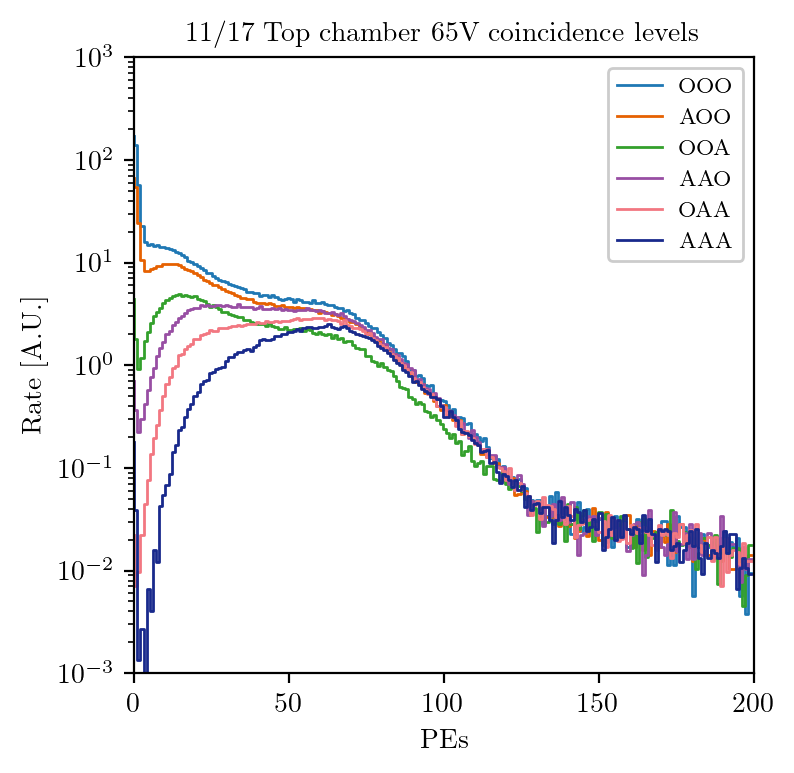

In [9]:
xmin = 0
xmax = 200
nbins = 200
bin_width = (xmax-xmin)/nbins

hist = []
hist_bins = []
plt.figure(0,figsize=(4,4))
for i,dset in enumerate(ds1117top):
    h,hx = np.histogram(dset.summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
#     h = h/dset.ch[0].cumulative_time/bin_width
    h = h/np.sum(h[int((150-xmin)/bin_width):])
    hist.append(h)
    hist_bins.append(hx)
    plt.step(hx[:-1], h, label=coinc[i], linewidth=1)
    
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/17 Top chamber 65V coincidence levels')
plt.xlim(xmin, xmax)

# Fitting Attempt

In [20]:
def chisquare_two_hist(light_yield, enf, data_hist, data_hist_bins, data_hist_err, sim_tree, fit_range_in_pe):
    xmin = data_hist_bins[0]
    xmax = data_hist_bins[-1]
    nbins = len(data_hist_bins)
    bin_width = (xmax-xmin)/nbins
#     print(np.shape(data_hist), np.shape(data_hist_bins), np.shape(data_hist_err))
    
    simulated_pe = []
    for i,ev in enumerate(sim_tree):
        simulated_pe.append(normal(light_yield*sim_tree.Edep, np.sqrt(enf*light_yield*tr.Edep)))
    hSimPE, hSimPE_bins = np.histogram(simulated_pe, bins=np.linspace(xmin,xmax,nbins))
    hSimPE_err = np.sqrt(hSimPE)
#     print(np.shape(hSimPE), np.shape(hSimPE_bins), np.shape(hSimPE_err))
    simulated_pe = []
    fit_range_in_bin = [int((fit_range_in_pe[0]-xmin)/bin_width), int((fit_range_in_pe[1]-xmin)/bin_width)]
    norm_data = np.sum(data_hist[fit_range_in_bin[0]:fit_range_in_bin[1]])
    data_hist = data_hist/norm_data
    data_hist_err = data_hist_err/norm_data
    norm_sim = np.sum(hSimPE[fit_range_in_bin[0]:fit_range_in_bin[1]])
    hSimPE = hSimPE/norm_sim
    hSimPE_err = hSimPE_err/norm_sim
    chi_square = 0
    for i in range(fit_range_in_bin[0], fit_range_in_bin[1]):
        chi_square += (data_hist[i] - hSimPE[i])**2/((data_hist_err[i])**2 + (hSimPE_err[i])**2)
    dof = fit_range_in_pe[1]-fit_range_in_pe[0] - 3
    print(light_yield, enf, chi_square)
    return chi_square

In [3]:
dir1117 = [ '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/',
            '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_no_gamma/',
            '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma/',
            '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_bottom_light_scintillation_coinc_000_cond_no_gamma/']
labels = ['top', 'top bkg', 'bottom', 'bottom bkg']

In [4]:
ds1117 = []
# gain = [[T0,T1,T2,T3],[B0,B1,B2,B3]]
gain = [[556.758,548.693,548.862,541.270], [556.997, 503.579, 549.769, 558.519]]
for i,dir in enumerate(dir1117):
    data = ds.Dataset('', pol=-1, channels=range(4), spe=gain[i//2])
    for j in range(5):
        for ch in range(4):
            subdir = '{}{}/'.format(dir, j)
            print(subdir)
            data.ch[ch].path = subdir
            data.ch[ch].read_data()
            print('nevents={}'.format(data.ch[ch].nevents))
            data.ch[ch].baseline_subtraction()
            data.ch[ch].get_integral(prompt=0.5, long=5)
            data.ch[ch].clear()
    data.get_summed_integral_pe()
    ds1117.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/0/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/0/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/0/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/0/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/1/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000_cond_gamma/1/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_top_light_scintillation_coinc_000

nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma/3/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma/3/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma/3/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma/4/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma/4/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_bottom_light_scintillation_coinc_000_cond_gamma/4/
nevents=50000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-17/2022-11-17_volt_65_pos_b

(0.0, 250.0)

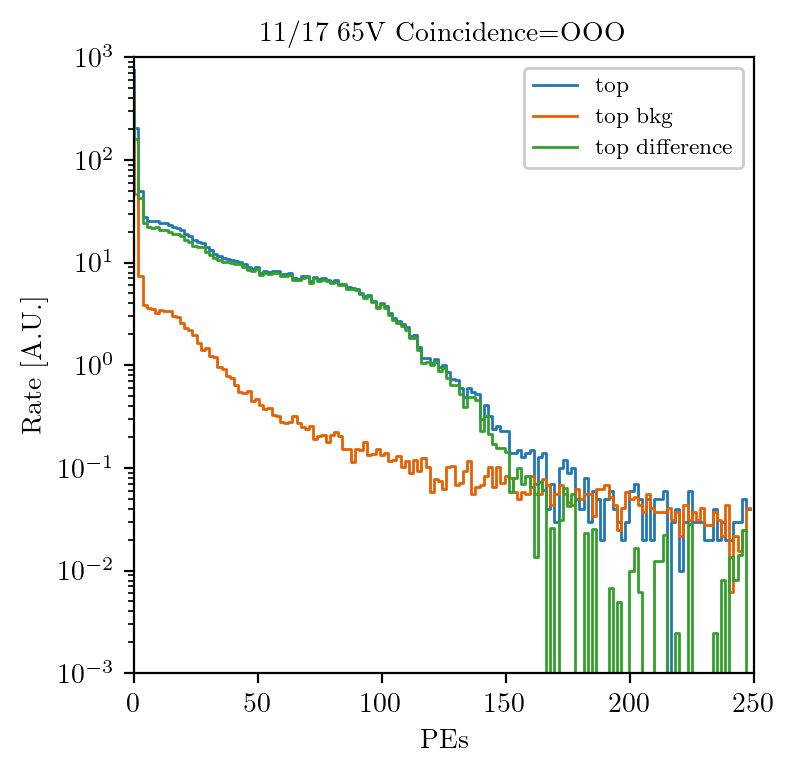

In [46]:
xmin = 0
xmax = 250
nbins = 150
bin_width = (xmax-xmin)/nbins

hist = [] #[top, top bkg, bot, bot bkg, top diff, bot diff]
hist_bins = []
hist_err = []
plt.figure(0,figsize=(4,4))
bkg_boundary = 200
for i,dset in enumerate(ds1117[:2]):
    h,hx = np.histogram(dset.summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
#     h = h/dset.ch[0].cumulative_time/bin_width
    norm_factor = np.sum(h[int((bkg_boundary-xmin)/bin_width):])
    hist_err.append(np.sqrt(h)/norm_factor)
    h = h/norm_factor
    hist.append(h)
    hist_bins.append(hx)
    plt.step(hx[:-1], h, label=labels[i], linewidth=1)
plt.step(hist_bins[0][:-1], hist[0]-hist[1], label='top difference', linewidth=1)
hist_bins.append(hist_bins[0])
hist.append(hist[0]-hist[1])
hist_err.append(np.sqrt(hist[0]**2+hist[1]**2))
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/17 65V Coincidence=OOO')
plt.xlim(xmin, xmax)

0.18 0.5 10.911403352392078
0.1875 0.5 6.24875355099719
0.195 0.5 2.855256049808556
0.20249999999999999 0.5 1.201860743347813
0.21 0.5 3.8593485938681975
0.18 1.625 5.802867925018834
0.1875 1.625 2.480384871928733
0.195 1.625 0.47132256918383314
0.20249999999999999 1.625 1.5555307232768338
0.21 1.625 5.472533401669865
0.18 2.75 2.9399051671326117
0.1875 2.75 1.126790984085616
0.195 2.75 0.8138837899069034
0.20249999999999999 2.75 3.6184426646368184
0.21 2.75 9.739319338956141
0.18 3.875 1.3958472853178407
0.1875 3.875 0.9982365543870153
0.195 3.875 3.4640389765275006
0.20249999999999999 3.875 7.330117444234788
0.21 3.875 15.734898071690145
0.18 5.0 1.1644623824974027
0.1875 5.0 2.2416045391351167
0.195 5.0 5.236729079642822
0.20249999999999999 5.0 12.757655460783205
0.21 5.0 22.133321261908016


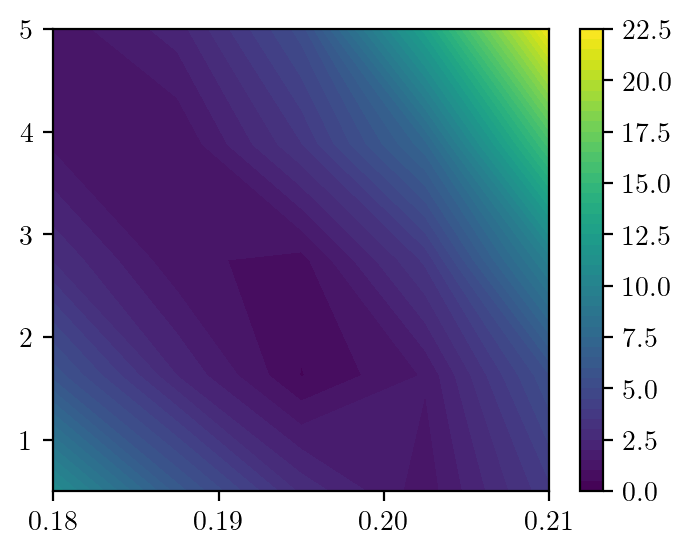

174324 events simulated


(0.01, 1000.0)

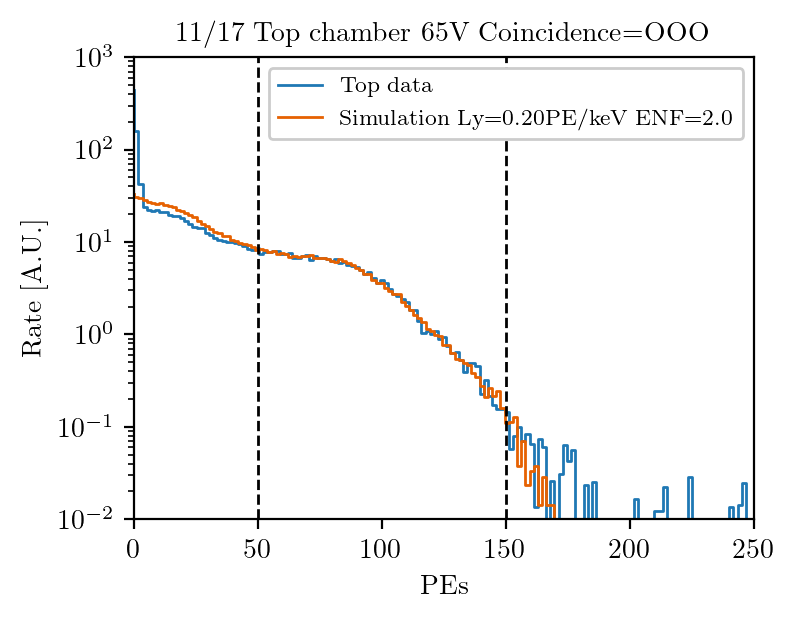

In [57]:
# TOP CHAMBER
file = ROOT.TFile("~/sipm-analysis/jupyter/pu_lar_cs137_Edep.root", "read")
tr = file.Get("trEdep")

lys = np.linspace(0.18, 0.21, 5)
enfs = np.linspace(0.5, 5, 5)
X,Y = np.meshgrid(lys, enfs)
fig,ax=plt.subplots(1,1)

norm_min = 50
norm_max = 150
cp=ax.contourf(X, Y, np.array([[chisquare_two_hist(ly_, enf_, hist[2], hist_bins[2], hist_err[2], tr, [norm_min,norm_max]) for ly_ in lys] for enf_ in enfs]), 50)
# cp=ax.contourf(X,Y,np.sqrt(X**2+Y**2))
fig.colorbar(cp) # Add a colorbar to a plot
plt.show()

ly = 0.195
enf = 2.0
simPE = []
nev = 0
for i,ev in enumerate(tr):
    for j in range(1):
        simPE.append(normal(ly*tr.Edep, np.sqrt(enf*ly*tr.Edep)))
        nev += 1
print('{} events simulated'.format(nev))
file.Close()

ymin = 1e-2
ymax = 1e3
hSimTop, hSimTop_bins = np.histogram(simPE, bins=np.linspace(xmin,xmax,nbins))
hSimTop = hSimTop*np.sum(hist[2][int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])/np.sum(hSimTop[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])
plt.step(hist_bins[2][:-1], hist[2], label='Top data', linewidth=1)
plt.step(hSimTop_bins[:-1], hSimTop, label='Simulation Ly={:.2f}PE/keV ENF={:.1f}'.format(ly, enf), linewidth=1)
plt.plot([norm_min, norm_min], [ymin, ymax], 'k--', linewidth=1)
plt.plot([norm_max, norm_max], [ymin, ymax], 'k--', linewidth=1)
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/17 Top chamber 65V Coincidence=OOO')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

(0.0, 1200.0)

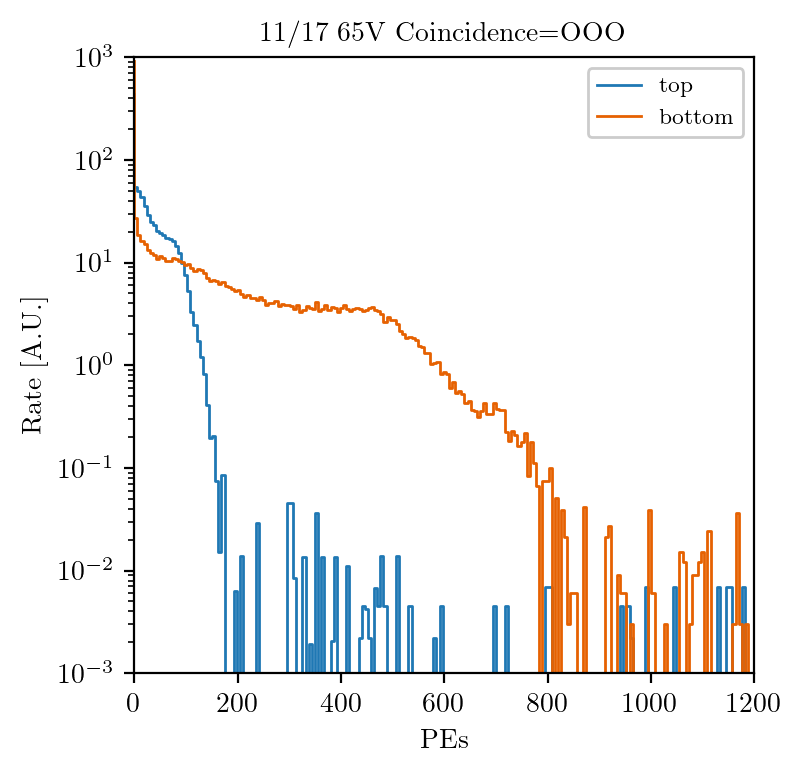

In [58]:
xmin = 0
xmax = 1200
nbins = 200
bin_width = (xmax-xmin)/nbins

hist = [] #[top, top bkg, bot, bot bkg, top diff, bot diff]
hist_bins = []
hist_err = []
plt.figure(0,figsize=(4,4))
bkg_boundary = [250, 250, 1000, 1000]
for i,dset in enumerate(ds1117):
    h,hx = np.histogram(dset.summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
#     h = h/dset.ch[0].cumulative_time/bin_width
    norm_factor = np.sum(h[int((bkg_boundary[i]-xmin)/bin_width):])
    h = h/norm_factor
    hist.append(h)
    hist_bins.append(hx)
    hist_err.append(np.sqrt(h)/norm_factor)
#     plt.step(hx[:-1], h, label=labels[i], linewidth=1)
    
plt.step(hist_bins[0][:-1], hist[0]-hist[1], label='top', linewidth=1)
hist_bins.append(hist_bins[0])
hist.append(hist[0]-hist[1])
hist_err.append(np.sqrt(hist[0]**2 + hist[1]**2))
plt.step(hist_bins[2][:-1], hist[2]-hist[3], label='bottom', linewidth=1)
hist_bins.append(hist_bins[2])
hist.append(hist[2]-hist[3])
hist_err.append(np.sqrt(hist[2]**2 + hist[3]**2))
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/17 65V Coincidence=OOO')
plt.xlim(xmin, xmax)

1.0 1.0 11.783736907546993
1.025 1.0 8.871095179328595
1.05 1.0 5.669849783865379
1.0750000000000002 1.0 4.140740759832866
1.1 1.0 5.462134775147347
1.0 3.25 6.900884795415045
1.025 3.25 4.050148881917539
1.05 3.25 1.7417875485551826
1.0750000000000002 3.25 1.6044096645929873
1.1 3.25 5.035929679671822
1.0 5.5 4.836727026171609
1.025 5.5 2.4847008939495185
1.05 5.5 1.5666724466051172
1.0750000000000002 5.5 2.759708197705846
1.1 5.5 6.414283731687032
1.0 7.75 3.4935603729199367
1.025 7.75 2.4535577806640507
1.05 7.75 2.583763658852739
1.0750000000000002 7.75 5.104430624466381
1.1 7.75 9.032992921082258
1.0 10.0 3.0220189872421157
1.025 10.0 2.6252742123845607
1.05 10.0 3.4463504460054186
1.0750000000000002 10.0 5.806725245522044
1.1 10.0 9.798788902529045


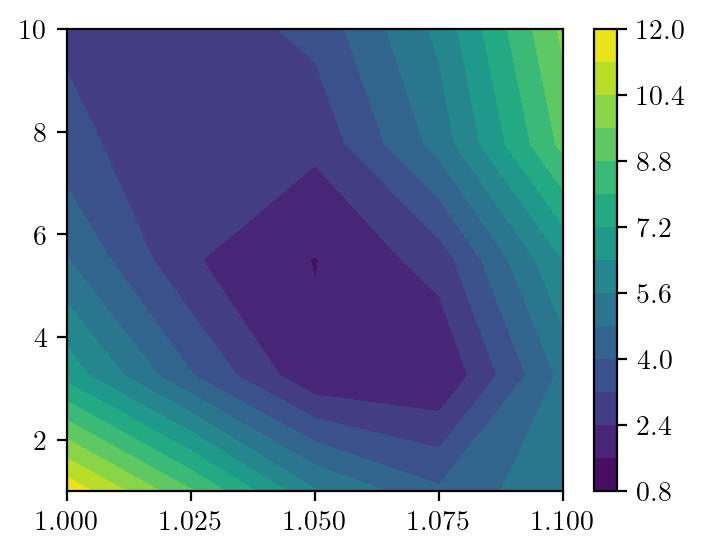

174324 events simulated


(0.01, 1000.0)

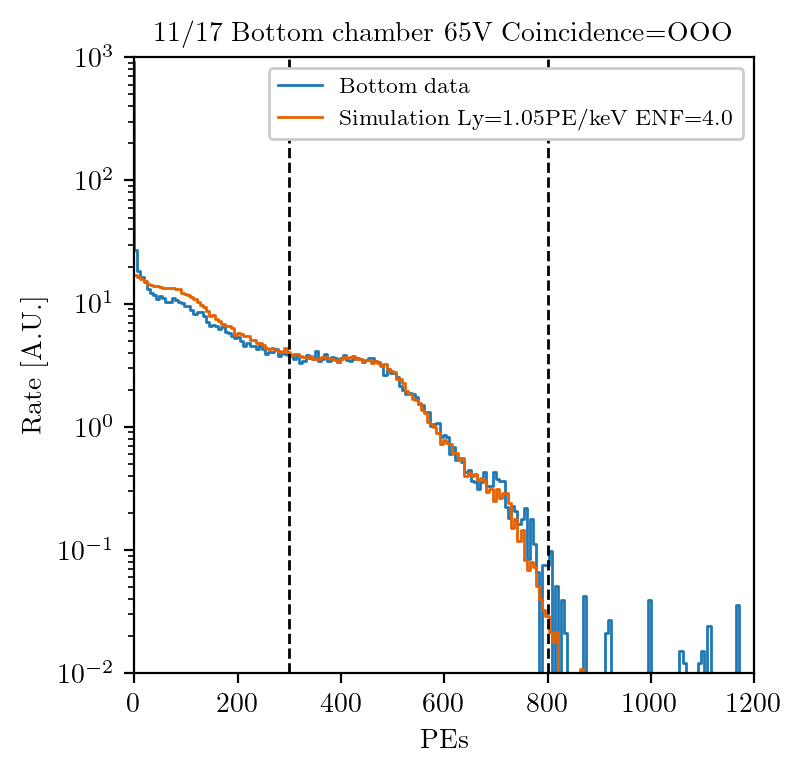

In [61]:
# BOTTOM CHAMBER
lys = np.linspace(1.00, 1.1, 5)
enfs = np.linspace(1, 10, 5)
X,Y = np.meshgrid(lys, enfs)
fig,ax=plt.subplots(1,1)
file = ROOT.TFile("~/sipm-analysis/jupyter/pu_lar_cs137_Edep.root", "read")
tr = file.Get("trEdep")

norm_min = 300
norm_max = 800
cp=ax.contourf(X, Y, np.array([[chisquare_two_hist(ly_, enf_, hist[5], hist_bins[5], hist_err[5], tr, [norm_min,norm_max]) for ly_ in lys] for enf_ in enfs]), 15)
# cp=ax.contourf(X,Y,np.sqrt(X**2+Y**2))
fig.colorbar(cp) # Add a colorbar to a plot
plt.show()

# Plot spectrum
plt.figure(1,figsize=(4,4))
ly = 1.05
enf = 4.
simPE = []
nev = 0
for i,ev in enumerate(tr):
    for j in range(1):
        simPE.append(normal(ly*tr.Edep, np.sqrt(enf*ly*tr.Edep)))
        nev += 1
print('{} events simulated'.format(nev))

ymin = 1e-2
ymax = 1e3
hSimBot, hSimBot_bins = np.histogram(simPE, bins=np.linspace(xmin,xmax,nbins))
hSimBot = hSimBot*np.sum(hist[5][int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])/np.sum(hSimBot[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])
plt.step(hist_bins[5][:-1], hist[5], label='Bottom data', linewidth=1)
plt.step(hSimBot_bins[:-1], hSimBot, label='Simulation Ly={:.2f}PE/keV ENF={:.1f}'.format(ly, enf), linewidth=1)
plt.plot([norm_min, norm_min], [ymin, ymax], 'k--', linewidth=1)
plt.plot([norm_max, norm_max], [ymin, ymax], 'k--', linewidth=1)
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/17 Bottom chamber 65V Coincidence=OOO')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# Test different bias voltage

In [2]:
!pwd

/home/as111/sipm-analysis


In [3]:
bias = [63, 65, 67, 69, 71]

In [4]:
ds1120top = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/gamma_1120_{}V_top.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)
            
    print('Top {}V {} events loaded'.format(v, nev))
    ds1120top.append(dset)
    
ds1118top_bkg = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/backgrounds_1118_{}V_top.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)

    print('Top {}V {} events loaded'.format(v, nev))
    ds1118top_bkg.append(dset)

Top 63V 1003373 events loaded
Top 65V 1007528 events loaded
Top 67V 1016980 events loaded
Top 69V 1014919 events loaded
Top 71V 1015092 events loaded
Top 63V 217218 events loaded
Top 65V 217008 events loaded
Top 67V 218302 events loaded
Top 69V 217576 events loaded
Top 71V 216743 events loaded


## Baseline cut

Text(0, 0.5, 'Count')

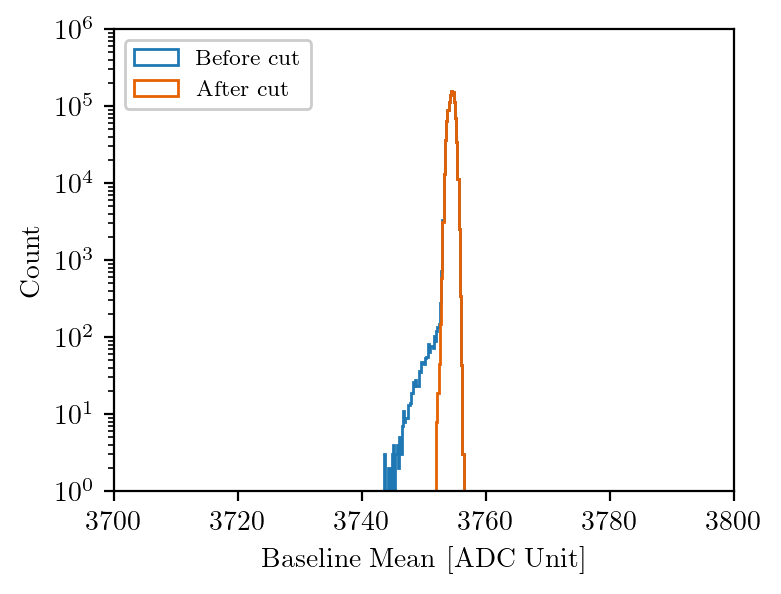

In [5]:
i=0
ch=0
dset = ds1120top[i].ch[ch]

nbins = 500
range_min = 3700
range_max = 3800
bin_width = (range_max-range_min)/nbins

bsl_avg_cut = []
for ev,avg in enumerate(dset.baseline_avg):
    if dset.baseline_std[ev]<2.5:
        bsl_avg_cut.append(avg)

plt.hist(dset.baseline_avg, label='Before cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.hist(bsl_avg_cut, label='After cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.legend()
plt.yscale('log')
plt.xlabel('Baseline Mean [ADC Unit]')
plt.ylabel('Count')

## Fprompt cut

Text(0, 0.5, '$F_{\\rm prompt}$')

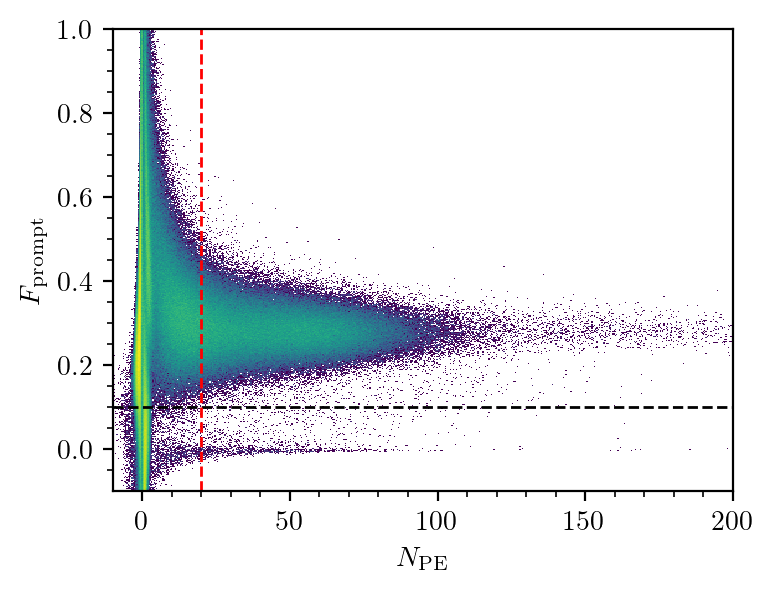

In [6]:
import matplotlib.colors as colors

i=0
dset = ds1120top[i]

nbinsx = 500
range_minx = -10
range_maxx = 200
nbinsy = 500
range_miny = -0.1
range_maxy = 1

fp_cut = 0.1
threshold = 20

plt.hist2d(dset.summed_integral_pe, dset.fprompt, bins=[np.linspace(range_minx, range_maxx, nbinsx+1), np.linspace(range_miny, range_maxy, nbinsy+1)], norm = colors.LogNorm())
plt.plot([range_minx, range_maxx], [fp_cut]*2, 'k--', linewidth=1)
plt.plot([threshold, threshold], [range_miny, range_maxy], 'r--', linewidth=1)
plt.minorticks_on()
plt.xlabel(r'$N_{\rm PE}$')
plt.ylabel(r'$F_{\rm prompt}$')

In [7]:
for i,v in enumerate(bias):
    dset = ds1120top[i]
    pe_cut = []
    for ev,fp in enumerate(dset.fprompt):
        if fp>fp_cut:
            pe_cut.append(dset.summed_integral_pe[ev])
    dset.summed_integral_pe = pe_cut

    dset = ds1118top_bkg[i]
    pe_cut = []
    for ev,fp in enumerate(dset.fprompt):
        if fp>fp_cut:
            pe_cut.append(dset.summed_integral_pe[ev])
    dset.summed_integral_pe = pe_cut


## Draw spectra

(0.0001, 10000000.0)

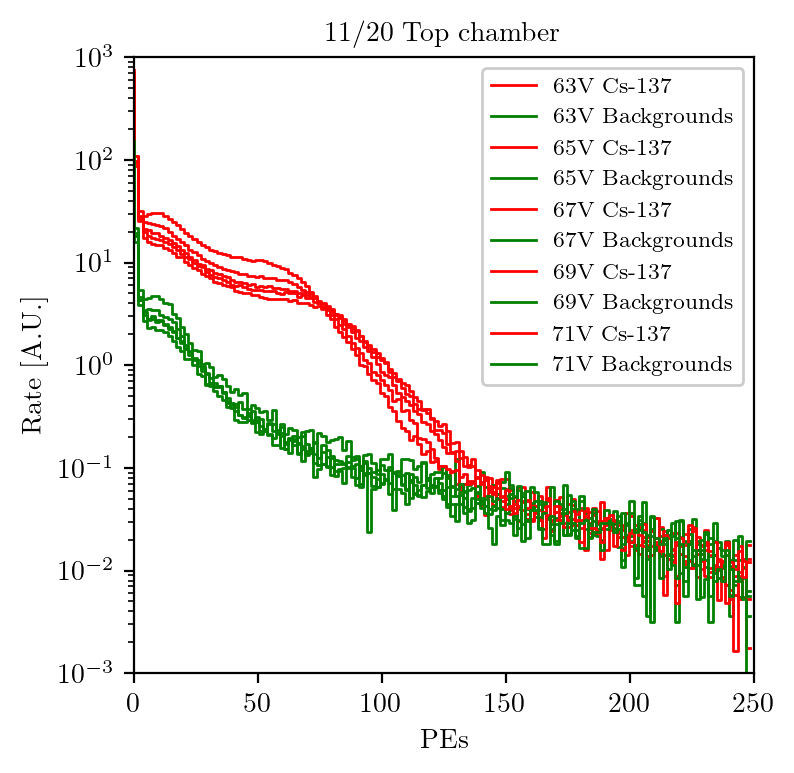

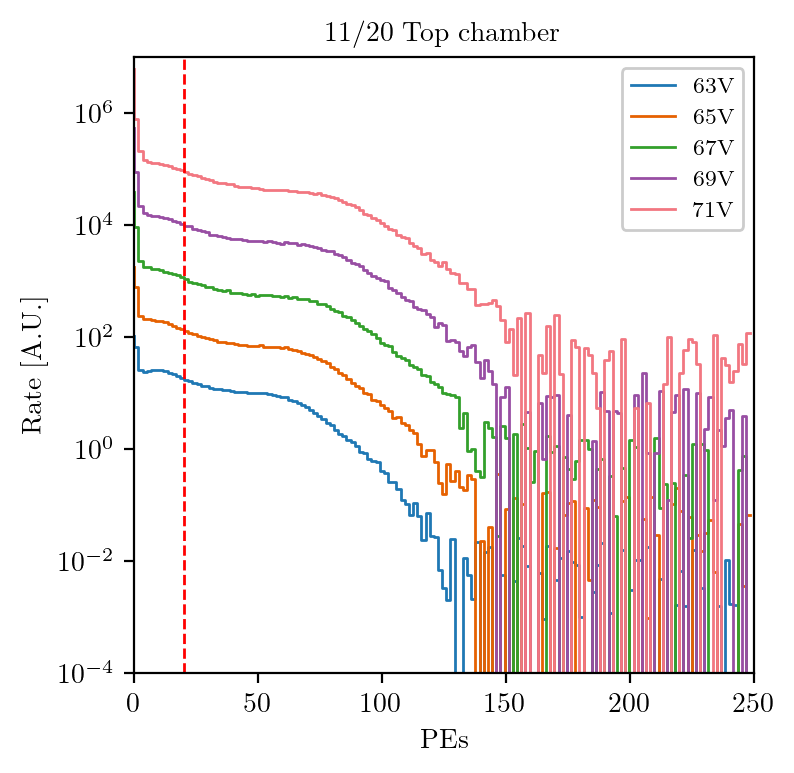

In [8]:
xmin = 0
xmax = 250
nbins = 150
bin_width = (xmax-xmin)/nbins

hist_gamma = []
hist_gamma_bins = []
hist_bkg = []
hist_bkg_bins = []
hist_dif = []
hist_dif_bins = []
source = ['Cs-137', 'Backgrounds']
color = ['r', 'g']
bkg_boundary = [170, 170, 170, 170, 170]
# scale = [3.3, 2.2, 1.7, 1.3, 1]
plt.figure(0,figsize=(4,4))
for i in range(len(ds1120top)):
    hg,hgx = np.histogram(ds1120top[i].summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    # hg = hg/dset.ch[0].cumulative_time/bin_width
    hg = hg/np.sum(hg[int((bkg_boundary[i]-xmin)/bin_width):])
    hist_gamma.append(hg)
    hist_gamma_bins.append(hgx)
    plt.step(hgx[:-1], hg, '{}'.format(color[0]), label='{}V {}'.format(bias[i], source[0]), linewidth=1)

    hb,hbx = np.histogram(ds1118top_bkg[i].summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    hb = hb/np.sum(hb[int((bkg_boundary[i]-xmin)/bin_width):])
    hist_bkg.append(hb)
    hist_bkg_bins.append(hbx)
    plt.step(hbx[:-1], hb, '{}'.format(color[1]), label='{}V {}'.format(bias[i], source[1]), linewidth=1)

plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/20 Top chamber')
plt.xlim(xmin, xmax)


plt.figure(1,figsize=(4,4))
ymin = 1e-4
ymax = 1e7
hist_dif_bins = hist_gamma_bins
for i in range(len(hist_gamma)):
    hist_dif.append(hist_gamma[i]-hist_bkg[i])
    plt.step(hist_dif_bins[i][:-1], hist_dif[i]*10**i, label='{}V'.format(bias[i]), linewidth=1)
plt.plot([threshold,threshold], [ymin,ymax], 'r--', linewidth=1)
    
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/20 Top chamber')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# Bottom data 11/20

In [9]:
ds1120bot = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/gamma_1120_{}V_bottom.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)
            
    print('Bottom {}V {} events loaded'.format(v, nev))
    ds1120bot.append(dset)
    
ds1118bot_bkg = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/backgrounds_1118_{}V_bottom.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)

    print('Bottom {}V {} events loaded'.format(v, nev))
    ds1118bot_bkg.append(dset)

Bottom 63V 1014166 events loaded
Bottom 65V 1015363 events loaded
Bottom 67V 1015290 events loaded
Bottom 69V 1014591 events loaded
Bottom 71V 1015157 events loaded
Bottom 63V 216580 events loaded
Bottom 65V 216617 events loaded
Bottom 67V 217771 events loaded
Bottom 69V 217350 events loaded
Bottom 71V 218261 events loaded


# Baseline cut

Text(0, 0.5, 'Count')

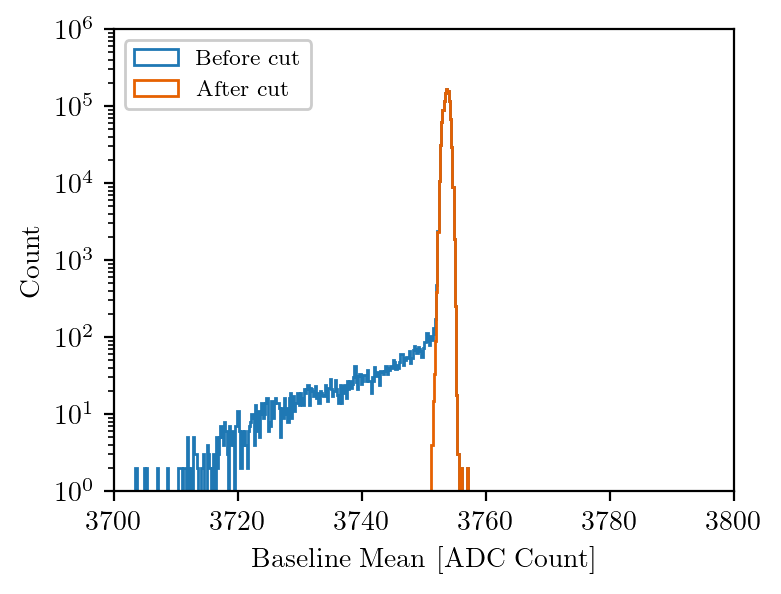

In [10]:
i=0
ch=0
dset = ds1120bot[i].ch[ch]

nbins = 500
range_min = 3700
range_max = 3800
bin_width = (range_max-range_min)/nbins

bsl_avg_cut = []
for ev,avg in enumerate(dset.baseline_avg):
    if dset.baseline_std[ev]<2.5:
        bsl_avg_cut.append(avg)

plt.hist(dset.baseline_avg, label='Before cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.hist(bsl_avg_cut, label='After cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.legend()
plt.yscale('log')
plt.xlabel('Baseline Mean [ADC Count]')
plt.ylabel('Count')

# Fprompt cut

Text(0, 0.5, '$F_{\\rm prompt}$')

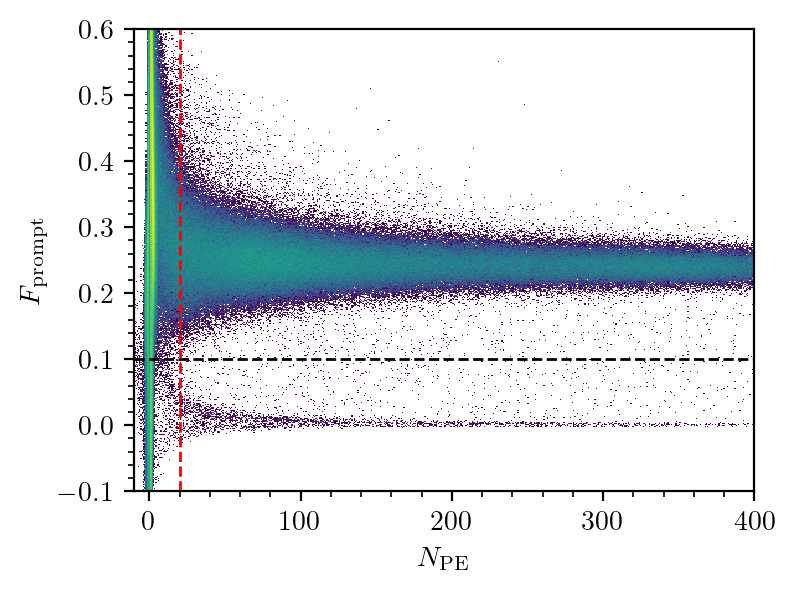

In [11]:
import matplotlib.colors as colors

i=0
dset = ds1120bot[i]

nbinsx = 500
range_minx = -10
range_maxx = 400
nbinsy = 500
range_miny = -0.1
range_maxy = 0.6

fp_cut = 0.1
threshold = 20

plt.hist2d(dset.summed_integral_pe, dset.fprompt, bins=[np.linspace(range_minx, range_maxx, nbinsx+1), np.linspace(range_miny, range_maxy, nbinsy+1)], norm = colors.LogNorm())
plt.plot([range_minx, range_maxx], [fp_cut]*2, 'k--', linewidth=1)
plt.plot([threshold, threshold], [range_miny, range_maxy], 'r--', linewidth=1)
plt.minorticks_on()
plt.xlabel(r'$N_{\rm PE}$')
plt.ylabel(r'$F_{\rm prompt}$')

In [12]:
for i,v in enumerate(bias):
    dset = ds1120bot[i]
    pe_cut = []
    for ev,fp in enumerate(dset.fprompt):
        if fp>fp_cut:
            pe_cut.append(dset.summed_integral_pe[ev])
    dset.summed_integral_pe = pe_cut

    dset = ds1118bot_bkg[i]
    pe_cut = []
    for ev,fp in enumerate(dset.fprompt):
        if fp>fp_cut:
            pe_cut.append(dset.summed_integral_pe[ev])
    dset.summed_integral_pe = pe_cut


## Draw spectra

(0.0, 1200.0)

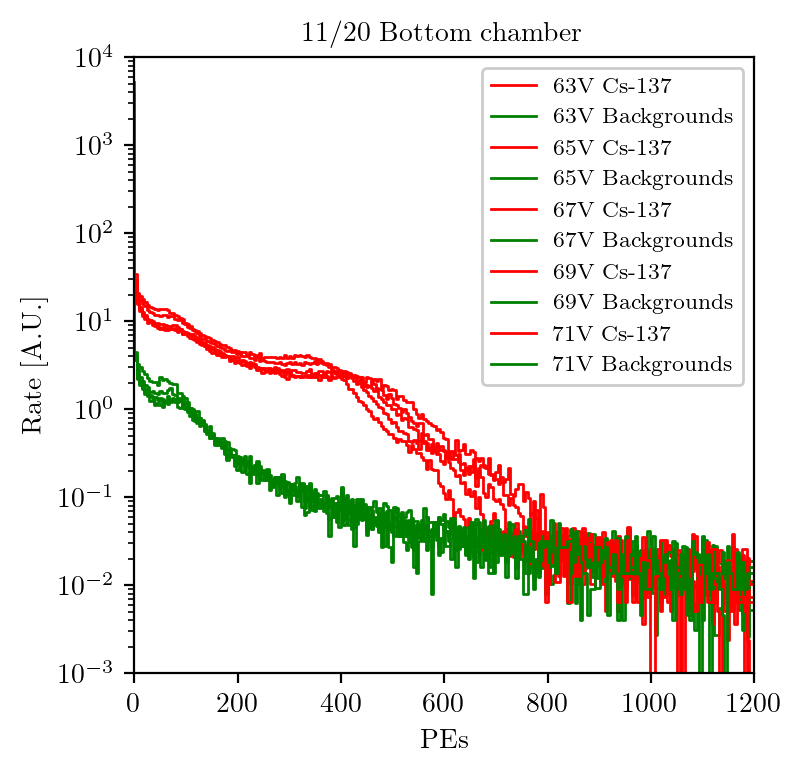

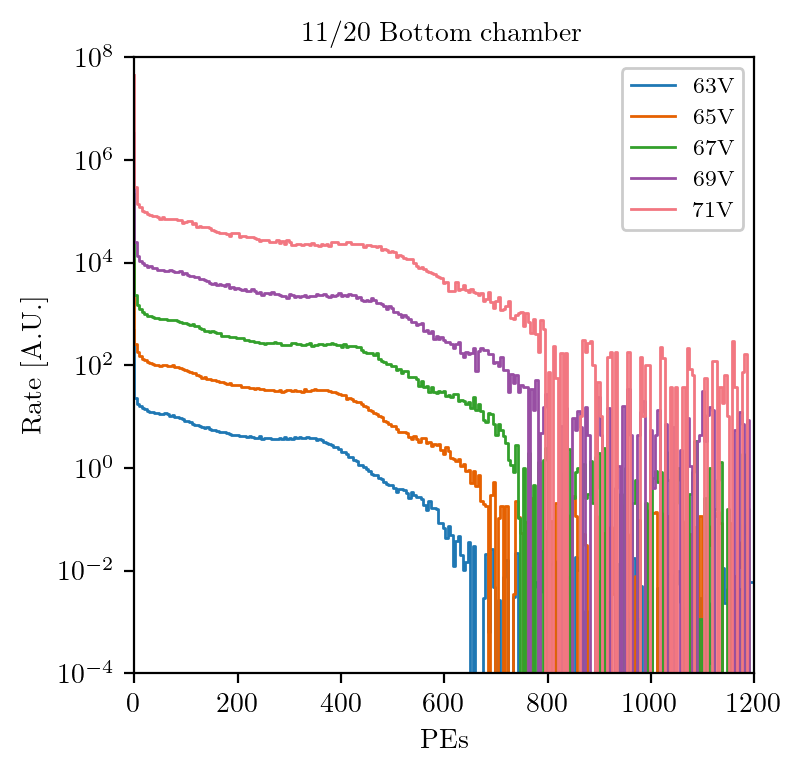

In [13]:
xmin = 0
xmax = 1200
nbins = 250
bin_width = (xmax-xmin)/nbins

hist_gamma = []
hist_gamma_bins = []
hist_bkg = []
hist_bkg_bins = []
hist_dif = []
hist_dif_bins = []
source = ['Cs-137', 'Backgrounds']
color = ['r', 'g']
bkg_boundary = [900, 900, 900, 900, 900]
# scale = [3.3, 2.2, 1.7, 1.3, 1]
plt.figure(0,figsize=(4,4))
for i in range(len(ds1120bot)):
    hg,hgx = np.histogram(ds1120bot[i].summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    # hg = hg/dset.ch[0].cumulative_time/bin_width
    hg = hg/np.sum(hg[int((bkg_boundary[i]-xmin)/bin_width):])
    hist_gamma.append(hg)
    hist_gamma_bins.append(hgx)
    plt.step(hgx[:-1], hg, '{}'.format(color[0]), label='{}V {}'.format(bias[i], source[0]), linewidth=1)

    hb,hbx = np.histogram(ds1118bot_bkg[i].summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    hb = hb/np.sum(hb[int((bkg_boundary[i]-xmin)/bin_width):])
    hist_bkg.append(hb)
    hist_bkg_bins.append(hbx)
    plt.step(hbx[:-1], hb, '{}'.format(color[1]), label='{}V {}'.format(bias[i], source[1]), linewidth=1)

plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/20 Bottom chamber')
plt.xlim(xmin, xmax)


plt.figure(1,figsize=(4,4))
hist_dif_bins = hist_gamma_bins
for i in range(len(hist_gamma)):
    hist_dif.append(hist_gamma[i]-hist_bkg[i])
    plt.step(hist_dif_bins[i][:-1], hist_dif[i]*10**i, label='{}V'.format(bias[i]), linewidth=1)
    
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/20 Bottom chamber')
plt.xlim(xmin, xmax)